In [4]:
def load_advs(path):
    res = np.load(path, allow_pickle=True).item()
    itr = max(res.keys())
    return res[itr]['adv'].squeeze()

def load_weights(path):
    adv = load_advs(path)
    w = adv - adv.min()
    w = w / w.sum() * w.shape[0]
    return w

def linear_weights(adv, p_base):
    w = (adv - adv.min()) /  (adv.max() - adv.min()) + p_base
    w = w / w.sum() * w.shape[0]
    return w

def scale(w, s):
    return np.maximum((w - w.mean())  * s + w.mean(), 0)



In [5]:
import matplotlib.pyplot as plt
import gym
import numpy as np

def vis(dist, bins):
  plt.hist(dist, bins=bins)
  plt.show()

# vis(d4rl.qlearning_dataset('hopper-medium-replay-v2'))


In [6]:
def get_std(envs, rp, wp, p_base=0):
    std = {}
    for env in envs:
        env_std = {}
        print(env, end=' ')
        returns = np.load(rp%env)
        rw = linear_weights(returns, p_base)
        print(rw.std().round(2), end=' ')
        env_std['return'] = rw.std()
        for iter in range(1,6):
            weight_list = []
            for seed in range(1,4):
                eval_res = np.load(wp%(env, seed), allow_pickle=True).item()
                num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']
                assert iter <= num_iter
                weights = eval_res[iter].squeeze()
                weight_list.append(weights)
            avg_weight = np.array(weight_list).mean(axis=0)
            print(avg_weight.std().round(2), end=' ')
            env_std[iter] = avg_weight.std()
        std[env] = env_std
        print('')
    return std

env1 = [f'{env}-{level}-v2' for env in ['walker2d', 'hopper', 'halfcheetah']
    for level in ['medium', 'medium-replay', 'medium-expert']]
env2 = ['antmaze-umaze-v0', 'antmaze-umaze-diverse-v0', 'antmaze-medium-play-v0',
            'antmaze-medium-diverse-v0', 'antmaze-large-play-v0', 'antmaze-large-diverse-v0']
env3 = ['kitchen-partial-v0', 'pen-human-v0', 'kitchen-complete-v0', 'kitchen-mixed-v0', 'pen-cloned-v0']
rp = f'weights/%s_returns.npy'
wp1 = wp2 = f'./weights/1000000_5_1000000_scale=False_%s_%s.npy'
wp3 = f'./weights/nstep_nstep_nstep=5_500000_5_500000_%s_%s.npy'

std1 = get_std(env1, rp, wp1)
std2 = get_std(env2, rp, wp2, p_base=0.2)
std3 = get_std(env3, rp, wp3)

walker2d-medium-v2 0.31 0.03 0.06 0.08 0.11 0.12 
walker2d-medium-replay-v2 0.78 0.08 0.13 0.17 0.2 0.23 
walker2d-medium-expert-v2 0.29 0.03 0.06 0.07 0.09 0.1 
hopper-medium-v2 0.28 0.03 0.06 0.08 0.1 0.12 
hopper-medium-replay-v2 0.8 0.02 0.04 0.06 0.07 0.09 
hopper-medium-expert-v2 0.48 0.01 0.01 0.02 0.02 0.02 
halfcheetah-medium-v2 0.07 0.03 0.04 0.06 0.08 0.09 
halfcheetah-medium-replay-v2 0.45 0.05 0.07 0.09 0.11 0.13 
halfcheetah-medium-expert-v2 0.37 0.01 0.02 0.03 0.04 0.05 
antmaze-umaze-v0 0.99 0.05 0.08 0.11 0.14 0.16 
antmaze-umaze-diverse-v0 0.37 0.03 0.04 0.07 0.1 0.14 
antmaze-medium-play-v0 1.01 0.01 0.02 0.03 0.05 0.07 
antmaze-medium-diverse-v0 0.92 0.01 0.02 0.02 0.03 0.04 
antmaze-large-play-v0 0.95 0.02 0.04 0.05 0.06 0.07 
antmaze-large-diverse-v0 0.94 0.01 0.03 0.04 0.05 0.06 
kitchen-partial-v0 0.41 0.07 0.13 0.18 0.22 0.26 
pen-human-v0 0.79 0.12 0.14 0.16 0.17 0.18 
kitchen-complete-v0 0.66 0.17 0.22 0.25 0.26 0.28 
kitchen-mixed-v0 0.2 0.07 0.11 0.13 0.16 

In [14]:
import matplotlib.pyplot as plt

def plot_multiple_curves(x, y_list, oracle_list, labels, colors):
    for i in range(len(y_list)):
        plt.plot(x, y_list[i], linestyle='-.', label=labels[i], color=colors[i], linewidth=1,
            marker='x', markersize=4, markeredgewidth = 1,)
        plt.axhline(y=oracle_list[i], linestyle='--', color=colors[i],linewidth=1)
    plt.xticks(x)
    plt.legend(prop={'size': 6})
    plt.xlabel("iteration", fontsize = 10)
    plt.ylabel("standard deviation", fontsize = 10)
    plt.show()

def call_plot(std):
    x = [1, 2, 3, 4, 5]
    labels =[]
    y_list = []
    oracle_list = []
    for env, weights in std.items():
        labels.append(env)
        oracle_list.append(weights['return'])
        y_list.append([weights[iter] for iter in x])
    colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', 
'#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']

    plot_multiple_curves(x, y_list, oracle_list, labels, colors)

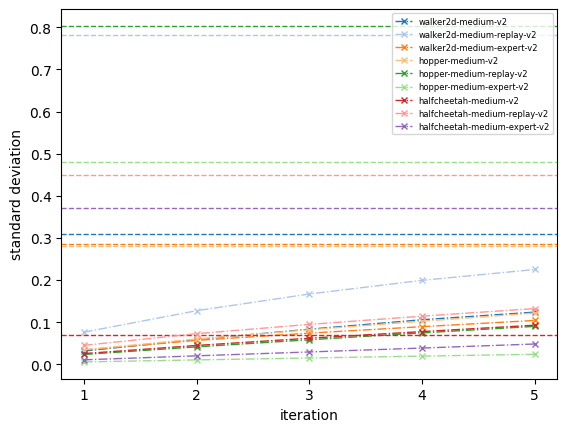

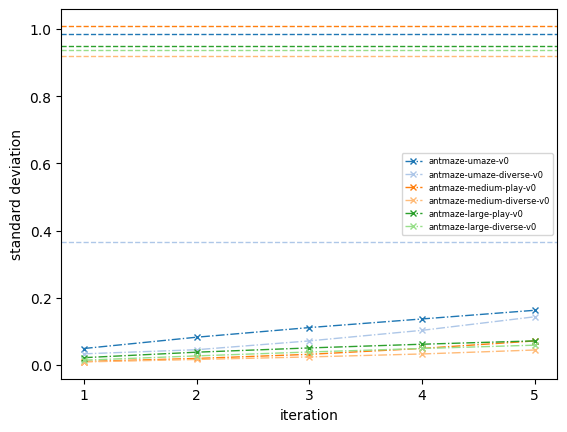

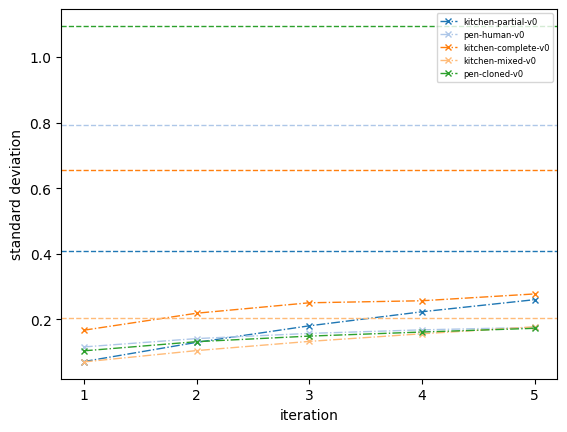

<Figure size 640x480 with 0 Axes>

In [16]:
call_plot(std1)
plt.savefig("results/mujoco_std.pdf", format='pdf', dpi=1200, bbox_inches='tight')
call_plot(std2)
plt.savefig("results/antmaze_std.pdf", format='pdf', dpi=1200, bbox_inches='tight')
call_plot(std3)
plt.savefig("results/adroit_std.pdf", format='pdf', dpi=1200, bbox_inches='tight')


antmaze-umaze-v0


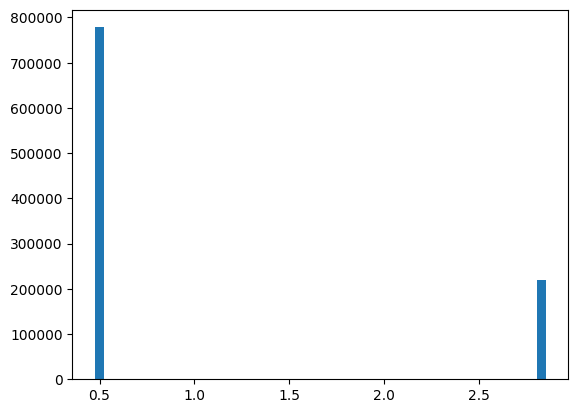

0.4755029517500873 2.85 0.99
[1.004 1.    0.995 0.995 0.998 0.993 0.994 0.997 1.003 1.004] 0.0 2.211 0.05
[1.006 0.995 0.995 0.981 0.999 0.996 0.991 1.002 0.995 1.024] 0.0 2.259 0.05
[0.989 1.005 0.991 0.988 1.007 0.987 0.982 1.002 0.999 1.019] 0.0 2.359 0.06


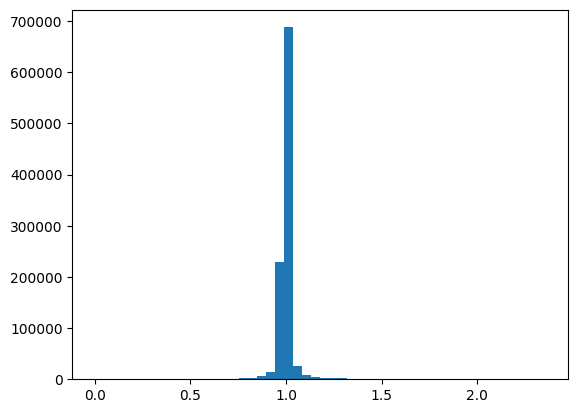

antmaze-umaze-diverse-v0


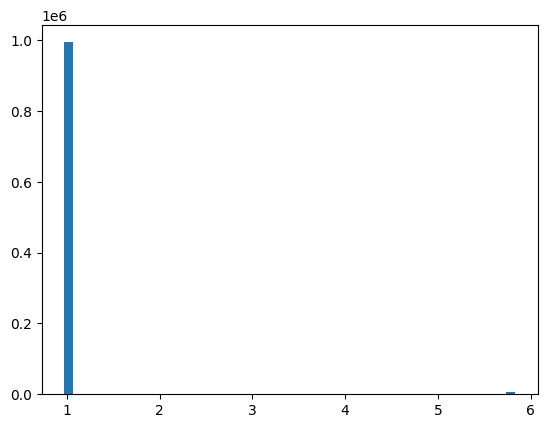

0.9721215321683303 5.83 0.37
[0.991 1.013 1.002 1.001 0.998 0.98  0.991 1.001 0.993 1.019] 0.0 11.646 0.04
[0.99  1.029 1.018 1.004 0.994 0.977 0.993 1.005 0.999 1.007] 0.0 11.926 0.04
[0.986 1.018 1.008 1.002 0.996 0.975 0.986 0.991 0.991 1.016] 0.0 14.512 0.04


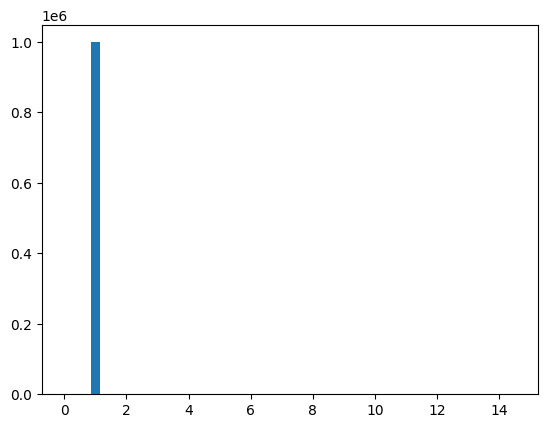

antmaze-medium-play-v0


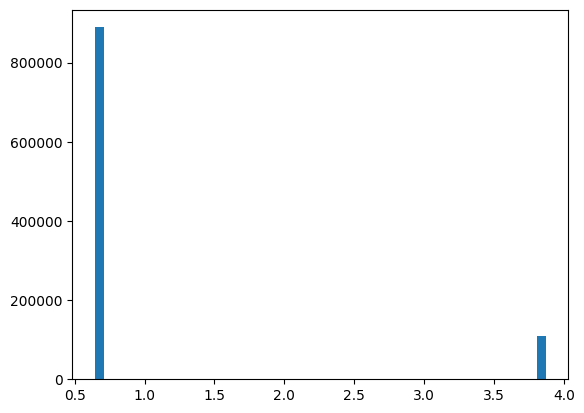

0.6449816902090788 3.87 1.01
[0.999 0.998 0.994 0.996 0.993 1.006 1.004 0.999 1.001 1.003] 0.0 1.837 0.01
[0.998 0.997 0.997 1.001 0.996 1.003 1.001 0.996 0.999 1.004] 0.0 1.82 0.01
[1.    1.    0.998 0.995 0.998 1.001 0.999 0.997 1.    1.007] 0.0 1.83 0.01


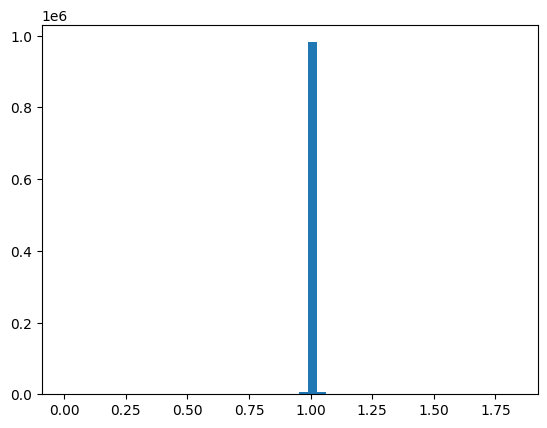

antmaze-medium-diverse-v0


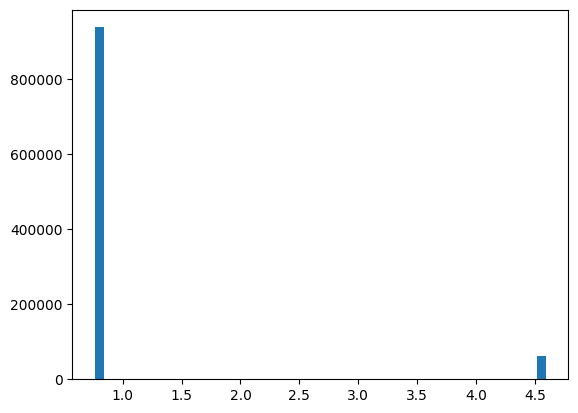

0.7650331156796142 4.59 0.92
[0.999 1.005 1.008 1.002 1.001 1.004 0.999 0.998 1.001 1.004] 0.0 1.916 0.01
[0.998 1.001 1.017 0.999 1.006 1.003 0.996 0.998 1.001 1.004] 0.0 1.926 0.01
[1.001 1.003 1.009 1.    1.002 1.005 1.    0.998 0.995 1.013] 0.0 1.922 0.01


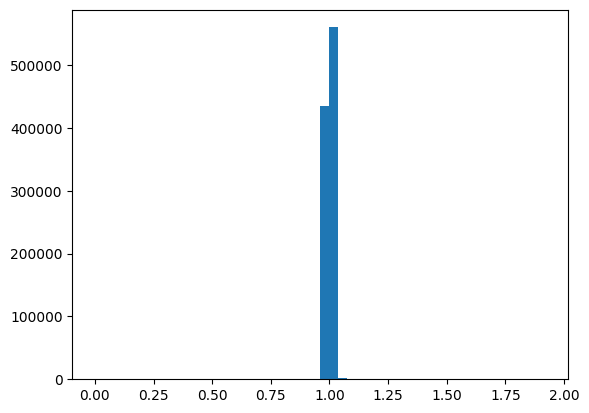

antmaze-large-play-v0


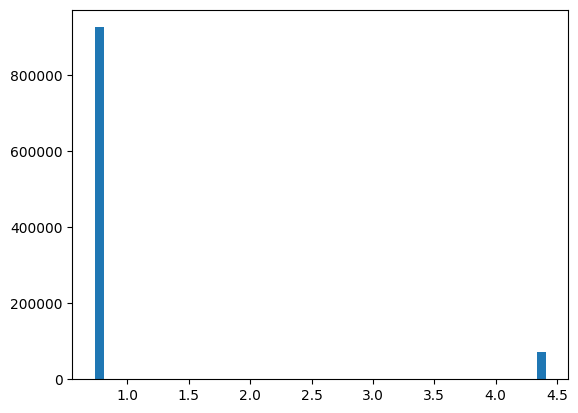

0.7346693931950767 4.41 0.95
[1.001 0.996 0.998 1.    0.999 0.998 0.999 0.993 0.999 0.997] 0.0 2.132 0.02
[1.    0.993 1.    0.995 1.005 1.    0.993 0.996 0.993 0.998] 0.0 2.346 0.02
[0.999 1.    0.997 0.998 1.003 0.994 0.999 0.998 0.996 1.   ] 0.0 1.783 0.02


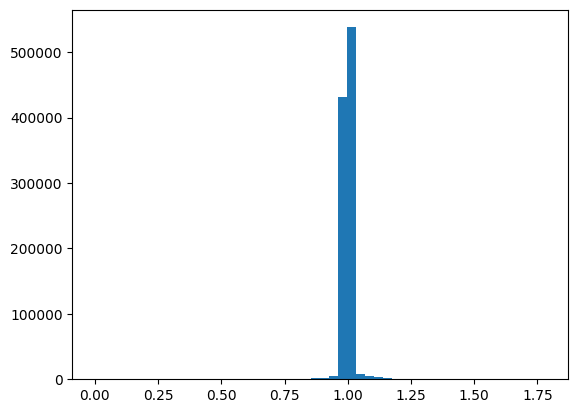

antmaze-large-diverse-v0


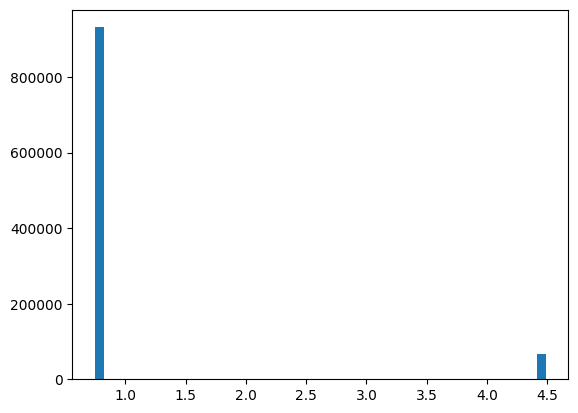

0.7479726602709889 4.49 0.94
[0.999 1.001 0.999 0.997 1.001 1.    0.999 0.994 1.002 1.002] 0.0 1.644 0.02
[0.999 1.001 0.998 0.997 1.001 1.    0.998 0.997 0.997 1.002] 0.0 1.603 0.02
[0.997 0.999 0.999 1.    1.002 0.998 0.997 1.001 0.995 1.002] 0.0 1.635 0.02


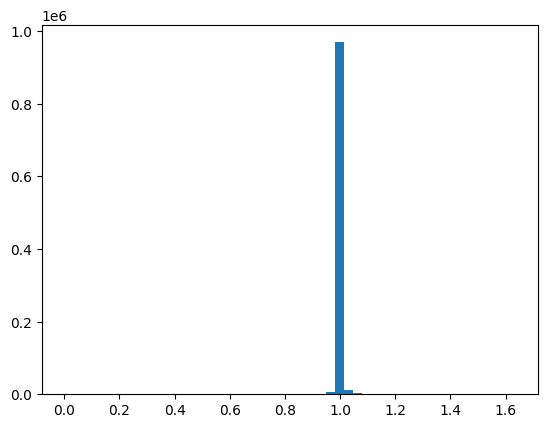

In [24]:
iter = 1
for env in ['antmaze-umaze-v0', 'antmaze-umaze-diverse-v0', 'antmaze-medium-play-v0',
 	    'antmaze-medium-diverse-v0', 'antmaze-large-play-v0', 'antmaze-large-diverse-v0']:
    print(env)
    rp = f'weights/{env}_returns.npy'
    returns = np.load(rp)
    # print(returns[:10])
    rw = linear_weights(returns)
    vis(rw, 50)
    print(rw.min(), rw.max().round(2), rw.std().round(2))
    for seed in range(1,4):
        wp = f'./weights/1000000_5_1000000_scale=False_{env}_%s.npy'%seed
        eval_res = np.load(wp, allow_pickle=True).item()
        num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']
        assert iter <= num_iter
        weights = eval_res[iter].squeeze().round(3)
        print(weights[180:190], weights.min(), weights.max(), weights.std().round(2))
    vis(weights, 50)

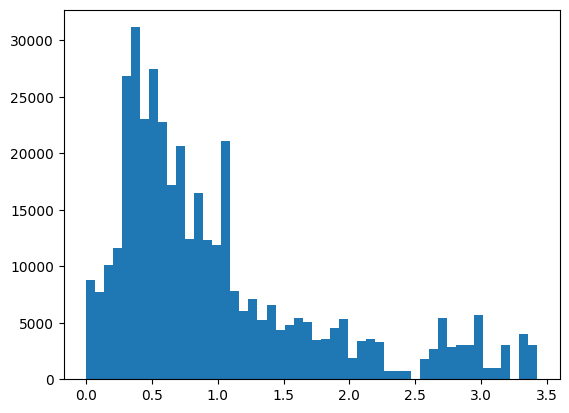

0.9999999427058299 0.8034304826878058
weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_1.npy


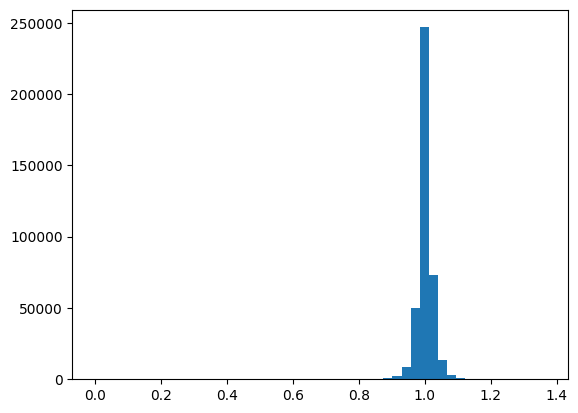

1.0 0.025337498104522856


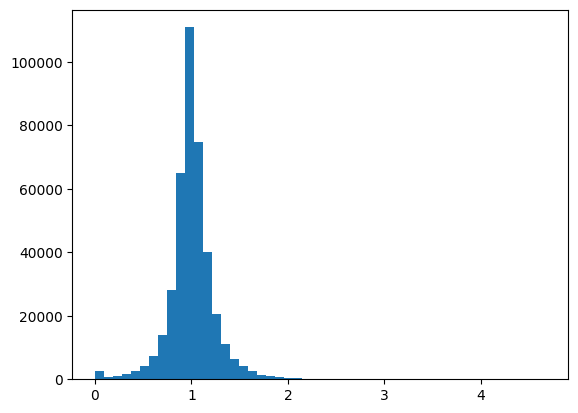

1.0027107941321027 0.23541832682082928
weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy


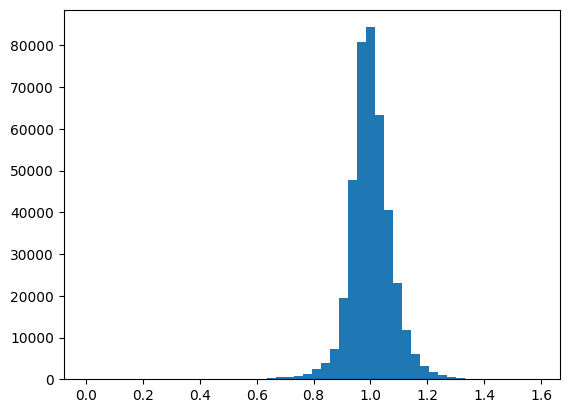

1.0000000000000002 0.07404391094701432


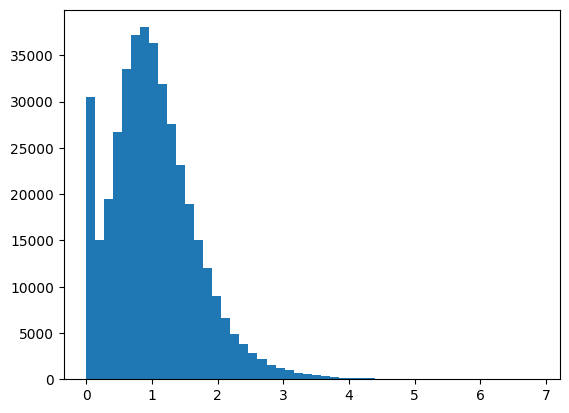

1.0337778636923363 0.6571395067228701
weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_1.npy


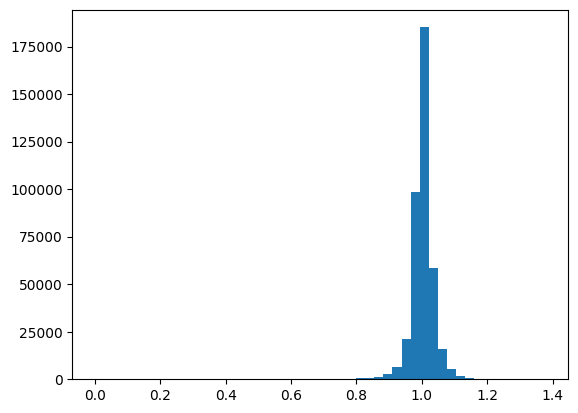

0.9999999250051804 0.04597116435996145


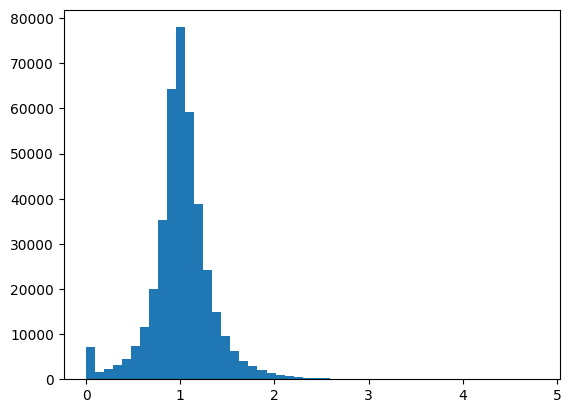

1.0184486229549898 0.32373681733750065
weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_1.npy


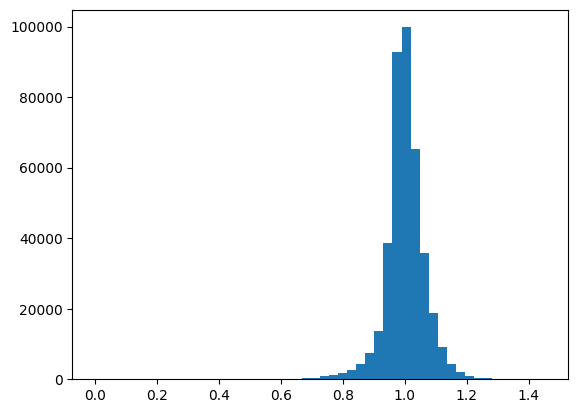

0.9999999999999997 0.06414245123866931


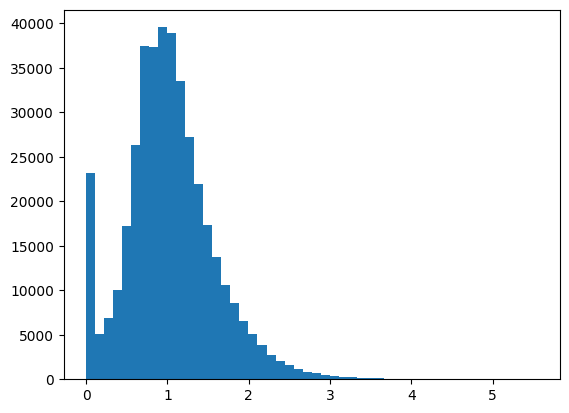

1.0322494572134644 0.5459042924552656
weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_3.npy


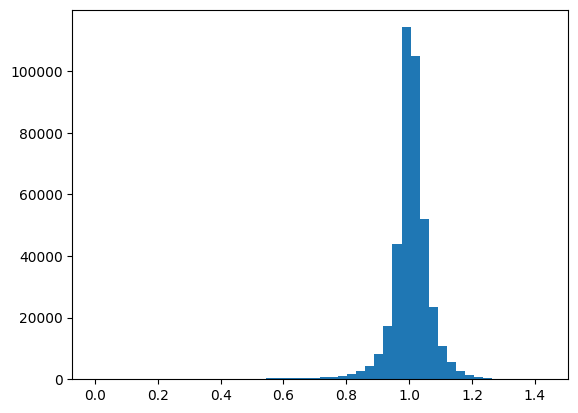

1.0000002770613745 0.0802258303323459


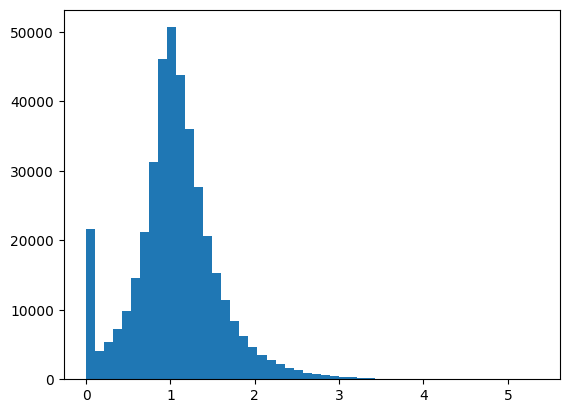

1.0655377160394193 0.5113169243538153
401598


In [5]:
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = [
    'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_1_0.95_cosine_hopper-medium-replay-v2_2.npy',
    'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_nstep_3_0.95_cosine_hopper-medium-replay-v2_3.npy',
    'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_1.npy',
    # 'weights/doublev_nstep_gae_3_0.95_cosine_hopper-medium-replay-v2_2.npy',
    # 'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_1.npy',
    'weights/doublev_nstep_nstep_10_0.95_cosine_hopper-medium-replay-v2_3.npy',
]

returns = np.load(rp)
rw = linear_weights(returns)
vis(rw, 50)
print(rw.mean(), rw.std())

for p in wp:
    print(p)
    adv = load_advs(p)
    w = linear_weights(adv)
    vis(w, 50)
    print(w.mean(), w.std())

    w = scale(w, 10)
    vis(w, 50)
    print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(adv.shape[0])


w = (A_i - A_min)/sum_i (A_i - A_min) * size

max ((w-1)*s + 1, 0.1)

In [ ]:
# check seeds and methods
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = 'weights/400000_6_200000_scale=False_halfcheetah-medium-expert-v2_1.npy'

returns = np.load(rp)
rw = linear_weights(returns)
print(rw.mean(), rw.std())
vis(rw, 50)

eval_res = np.load(wp, allow_pickle=True).item()
num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']

for iter in range(1,7):
    # step = iter*bc_eval_steps
    w = eval_res[iter]
    # w = linear_weights(adv)
    print(iter, w.max(), w.std())
    vis(w, 50)

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(w.shape[0])



In [ ]:
# check seeds and methods
rp = 'weights/hopper-medium-replay-v2_returns.npy'
wp = 'weights/doublev_nstep_nstep_1_0.95_cosine_5_400000_hopper-medium-replay-v2_1.npy'

returns = np.load(rp)
rw = linear_weights(returns)
vis(rw, 50)
print(rw.mean(), rw.std())

eval_res = np.load(wp, allow_pickle=True).item()
num_iter, bc_eval_steps = eval_res['iter'], eval_res['eval_steps']

for iter in range(1,6):
    step = iter*bc_eval_steps
    adv = eval_res[step]['adv']
    w = linear_weights(adv)
    print(step, w.max(), w.std())
    vis(w, 50)

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # print(p,'\n', adv[:20].squeeze().round(2))
print(adv.shape[0])



3.4268150170173612 0.8034304826878058


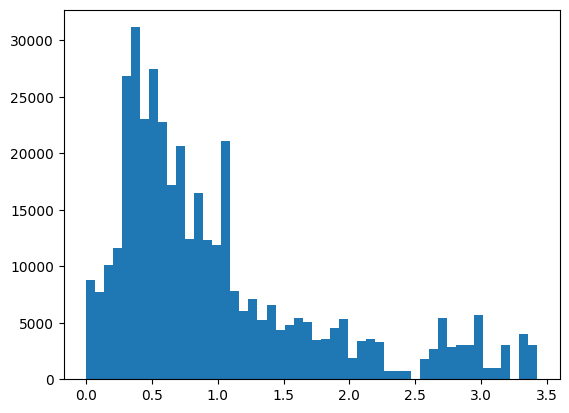

weights/400000_20_50000_scale=False_hopper-medium-replay-v2_3.npy
6.664821055496518 0.19093230232753106


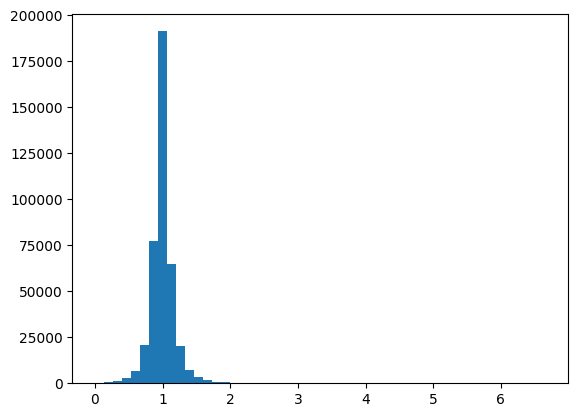

2.7316007806311973 0.7824851857866889


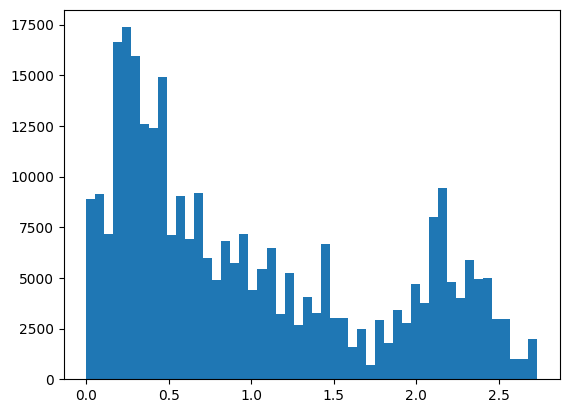

weights/400000_20_50000_scale=False_walker2d-medium-replay-v2_3.npy
15.953500083068354 0.4133502988523496


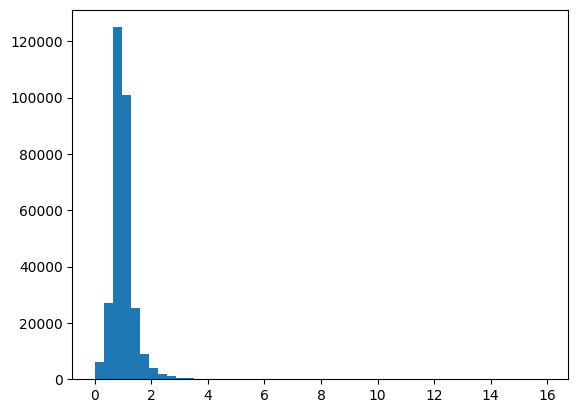

1.4409233491505802 0.3701735913368142


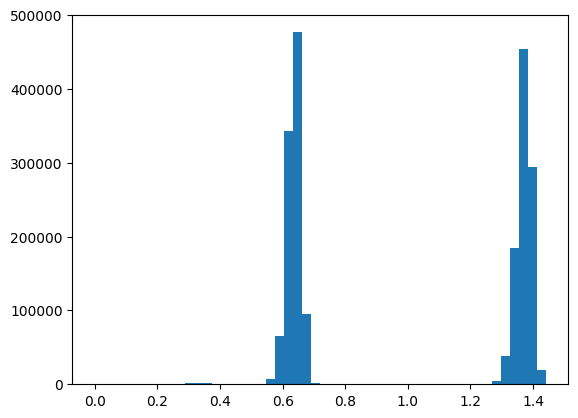

weights/400000_20_50000_scale=False_halfcheetah-medium-expert-v2_3.npy
38.77383609324387 0.2511794621774142


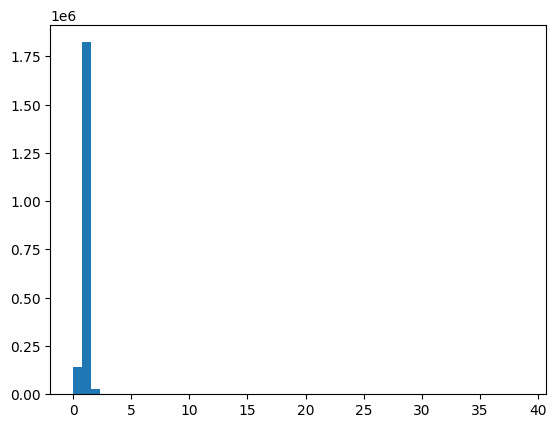

1.5555160083866895 0.4805471910882862


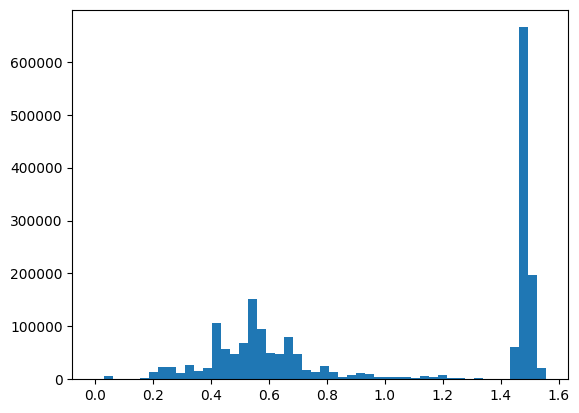

weights/400000_20_50000_scale=False_hopper-medium-expert-v2_3.npy
5.284510981209025 0.06070453009347458


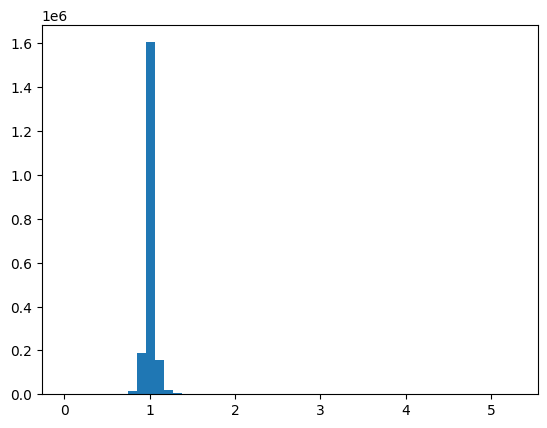

In [5]:
envs = ["hopper-medium-replay-v2", "walker2d-medium-replay-v2",
	"halfcheetah-medium-expert-v2", "hopper-medium-expert-v2"]

for env in envs:
    rp = f'weights/{env}_returns.npy'
    p = f'weights/400000_20_50000_scale=False_{env}_3.npy'

    returns = np.load(rp)
    rw = linear_weights(returns)
    print(rw.max(), rw.std())
    vis(rw, 50)

    eval_res = np.load(p, allow_pickle=True).item()
    w = eval_res[10]
    print(p)
    print(w.max(), w.std())
    vis(w, 50)
    

    # w = scale(w, 10)
    # vis(w, 50)
    # print(w.mean(), w.std())
    # # print(p,'\n', adv[:20].squeeze().round(2))
    # print(adv.shape[0])



In [ ]:
prefix = 'doublev_onestep_cosine'
for env in ['walker2d', 'hopper', 'halfcheetah']:
    for level in ['medium', 'medium-replay', 'medium-expert']:
        task = f'{env}-{level}-v2'
        print(task)
        for seed in range(6):
            path = f"./weights/{prefix}_{task}_{seed}.npy"
            weights = []
            if os.path.exists(path):
                weights.append(load_weights(path))
                print(f'seed {seed}', weights[-1].max().round(2), ' ', weights[-1][:10].round(2))
                idx = int(np.argmax(weights[-1], axis=0))
                print(weights[-1][idx-10:idx+10].round(2))
            else:
                print(f'{path} doesn\'t exists')
            
